In [ ]:
!pip install lightgbm optuna
!pip install optuna-integration[lightgbm]
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import optuna
from optuna.integration import LightGBMPruningCallback
import sys

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Senior_Thesis_Waseda/exp_Income_Level')

In [ ]:
%run ../evaluation.ipynb
%run ../training.ipynb
%run ../parameter_optimization.ipynb

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Senior_Thesis_Waseda/happiness_data.csv')
df.head()
df.shape

(97220, 82)

In [ ]:
income = pd.read_csv('/content/drive/MyDrive/Senior_Thesis_Waseda/happiness_data_pre_cluster.csv')
income = income.loc[:, ['D_INTERVIEW','Q288']]
income.head()

,D_INTERVIEW,Q288
0,196070011,5
1,196070036,5
2,196070039,3
3,196070040,5
4,196070053,3


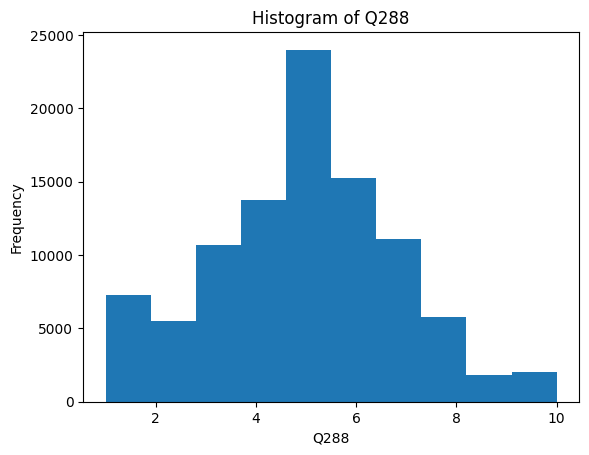

In [ ]:
import matplotlib.pyplot as plt

plt.hist(income['Q288'])
plt.xlabel('Q288')
plt.ylabel('Frequency')
plt.title('Histogram of Q288')
plt.show()

In [ ]:
df_merged = pd.merge(income, df, on='D_INTERVIEW')
df_merged.head()

,D_INTERVIEW,Q288,happiness,B_COUNTRY_ALPHA,G_TOWNSIZE,GDP group,H_SETTLEMENT,Cl_1,Cl_2,Cl_3,...,Cl_67,Cl_68,Cl_69,Cl_70,Cl_71,Cl_72,Cl_73,Cl_74,Cl_75,Cl_76
0,196070011,5,7.333333,CYP,6.0,1,4.0,0.936297,-0.623011,-1.308899,...,-1.675059,0.345000,0.976462,-1.848202,-1.456204,0.884878,2,1,6,3
1,196070036,5,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.580208,-0.332603,0.976462,-1.218074,-0.272563,0.884878,1,1,8,3
2,196070039,3,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.574066,0.146194,-0.200705,-0.266231,0.323946,0.268851,1,1,0,3
3,196070040,5,5.333333,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,-0.009851,0.143230,0.976462,-0.742153,-0.272563,0.884878,1,1,8,3
4,196070053,3,4.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.507466,-0.300418,0.386842,0.839819,0.915767,0.268851,2,5,8,3


In [ ]:
df_merged = df_merged[df_merged['Q288'] >= 7]
df_merged.head()

,D_INTERVIEW,Q288,happiness,B_COUNTRY_ALPHA,G_TOWNSIZE,GDP group,H_SETTLEMENT,Cl_1,Cl_2,Cl_3,...,Cl_67,Cl_68,Cl_69,Cl_70,Cl_71,Cl_72,Cl_73,Cl_74,Cl_75,Cl_76
32,218070170,8,8.666667,ECU,5.0,0,3.0,-1.068037,-0.623011,0.764001,...,0.180880,0.121692,0.101660,0.363897,0.915767,0.884878,1,6,7,1
35,218070199,8,9.333333,ECU,4.0,0,2.0,-1.068037,-0.623011,0.764001,...,-0.683162,-0.004687,0.976462,0.363897,0.915767,0.884878,1,2,6,1
46,218070373,10,9.333333,ECU,8.0,0,2.0,-1.068037,-0.623011,0.764001,...,-0.340029,0.069840,0.684170,1.469947,0.915767,0.257307,2,2,3,0
72,218070749,8,10.000000,ECU,7.0,0,3.0,-1.068037,-0.623011,0.764001,...,-0.074813,0.615970,0.976462,-0.266231,0.321602,0.884878,1,5,1,0
73,218070758,8,7.333333,ECU,5.0,0,3.0,0.936297,-0.623011,-1.308899,...,-0.119606,0.439354,0.976462,-0.266231,0.321602,0.884878,1,6,0,0


In [ ]:
categorical = ['Cl_73', 'Cl_74', 'Cl_75', 'Cl_76']

for col in categorical:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [ ]:
X = df_merged.loc[:, 'Cl_1':]
y = df_merged['happiness']

In [ ]:
parameter_optimization(X, y,
    save_path="exp_Income_high_best_params.json")

[I 2025-06-14 19:35:11,458] A new study created in memory with name: lgbm_regression_opt


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[451]	valid's rmse: 0.403856
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.412539
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.413716
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid's rmse: 0.419341
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[486]	valid's rmse: 0.411992


[I 2025-06-14 19:37:25,056] Trial 0 finished with value: 0.4122886281752092 and parameters: {'num_leaves': 37, 'learning_rate': 0.059662768998574464, 'max_depth': 12, 'reg_alpha': 0.01689821456403644, 'reg_lambda': 0.008733286960935062, 'feature_fraction': 0.5545578611806954, 'bagging_fraction': 0.7944205512826226, 'bagging_freq': 4, 'min_data_in_leaf': 483}. Best is trial 0 with value: 0.4122886281752092.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.544698
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.561121
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.556977
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.549615
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.551144


[I 2025-06-14 19:39:40,813] Trial 1 finished with value: 0.5527109103219019 and parameters: {'num_leaves': 124, 'learning_rate': 0.008135993077935482, 'max_depth': 11, 'reg_alpha': 0.00016165526881359486, 'reg_lambda': 0.7035409156988579, 'feature_fraction': 0.4019026700531766, 'bagging_fraction': 0.5756856352296862, 'bagging_freq': 5, 'min_data_in_leaf': 459}. Best is trial 0 with value: 0.4122886281752092.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.936256
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.945271
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.94108
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.937329
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.941229


[I 2025-06-14 19:42:15,720] Trial 2 finished with value: 0.9402331025332853 and parameters: {'num_leaves': 59, 'learning_rate': 0.0031419355583659327, 'max_depth': 9, 'reg_alpha': 8.662924996503568, 'reg_lambda': 0.02194583099502228, 'feature_fraction': 0.47397242771581266, 'bagging_fraction': 0.9496188320394634, 'bagging_freq': 7, 'min_data_in_leaf': 153}. Best is trial 0 with value: 0.4122886281752092.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.47736
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.48855
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.47521
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.47766
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.47262


[I 2025-06-14 19:43:45,333] Trial 3 finished with value: 1.4782779115812699 and parameters: {'num_leaves': 88, 'learning_rate': 0.0020393416894354194, 'max_depth': 3, 'reg_alpha': 0.004180382606157517, 'reg_lambda': 9.005175761589022, 'feature_fraction': 0.7078847726835956, 'bagging_fraction': 0.9258973847512997, 'bagging_freq': 1, 'min_data_in_leaf': 156}. Best is trial 0 with value: 0.4122886281752092.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[363]	valid's rmse: 0.395894
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.410057
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.413884
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.416563
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.415222


[I 2025-06-14 19:46:41,780] Trial 4 finished with value: 0.4103239078693096 and parameters: {'num_leaves': 81, 'learning_rate': 0.03338461566965746, 'max_depth': 12, 'reg_alpha': 0.009228237972087388, 'reg_lambda': 4.420164028591646, 'feature_fraction': 0.6997672062599631, 'bagging_fraction': 0.8812298141809676, 'bagging_freq': 7, 'min_data_in_leaf': 251}. Best is trial 4 with value: 0.4103239078693096.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.969774
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.976444
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.978688
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.978563
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.969635


[I 2025-06-14 19:49:09,862] Trial 5 finished with value: 0.9746207956137848 and parameters: {'num_leaves': 131, 'learning_rate': 0.0035756793567883233, 'max_depth': 6, 'reg_alpha': 0.0003352532574306502, 'reg_lambda': 0.04127989591553768, 'feature_fraction': 0.7891048128108265, 'bagging_fraction': 0.9397669501941917, 'bagging_freq': 1, 'min_data_in_leaf': 169}. Best is trial 4 with value: 0.4103239078693096.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[430]	valid's rmse: 0.404384
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[420]	valid's rmse: 0.41579
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.418266
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.420818
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[400]	valid's rmse: 0.421038


[I 2025-06-14 19:50:51,255] Trial 6 finished with value: 0.41605920423751985 and parameters: {'num_leaves': 30, 'learning_rate': 0.07511737052942642, 'max_depth': 12, 'reg_alpha': 0.0009040884568982261, 'reg_lambda': 5.889870175124454, 'feature_fraction': 0.6664289643882277, 'bagging_fraction': 0.5580546342887509, 'bagging_freq': 5, 'min_data_in_leaf': 200}. Best is trial 4 with value: 0.4103239078693096.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[471]	valid's rmse: 0.392362
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.409792
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.412666
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.413197
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[478]	valid's rmse: 0.413758


[I 2025-06-14 19:54:16,966] Trial 7 finished with value: 0.4083552313014998 and parameters: {'num_leaves': 149, 'learning_rate': 0.021584729121977998, 'max_depth': 12, 'reg_alpha': 7.376024827825465, 'reg_lambda': 0.0008077586571489891, 'feature_fraction': 0.6648231984664661, 'bagging_fraction': 0.8036760300859622, 'bagging_freq': 5, 'min_data_in_leaf': 204}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.40711
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.428599
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.433154
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.43047
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.42661


[I 2025-06-14 19:56:32,800] Trial 8 finished with value: 0.4251886893209715 and parameters: {'num_leaves': 107, 'learning_rate': 0.027521448316098446, 'max_depth': 10, 'reg_alpha': 0.004026360901338699, 'reg_lambda': 0.000305705563511273, 'feature_fraction': 0.9006505683344346, 'bagging_fraction': 0.4151335109209015, 'bagging_freq': 2, 'min_data_in_leaf': 432}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.26045
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.26777
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.26076
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.25922
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.26176


[I 2025-06-14 19:58:21,808] Trial 9 finished with value: 1.2619933405990973 and parameters: {'num_leaves': 26, 'learning_rate': 0.0024446594456802922, 'max_depth': 7, 'reg_alpha': 0.001499402648929466, 'reg_lambda': 0.006244650388242344, 'feature_fraction': 0.4870981102803031, 'bagging_fraction': 0.4813828127928418, 'bagging_freq': 1, 'min_data_in_leaf': 92}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 19:58:25,191] Trial 10 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.396471
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.41192
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.414531
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.417876
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.417349


[I 2025-06-14 20:01:02,704] Trial 11 finished with value: 0.41162971034956125 and parameters: {'num_leaves': 72, 'learning_rate': 0.028114034068820244, 'max_depth': 9, 'reg_alpha': 0.18049197303944922, 'reg_lambda': 0.34512409552326406, 'feature_fraction': 0.6296645942023187, 'bagging_fraction': 0.819810144023043, 'bagging_freq': 7, 'min_data_in_leaf': 284}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:01:07,295] Trial 12 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.406104
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.415832
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.420966
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[479]	valid's rmse: 0.42206
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[459]	valid's rmse: 0.417914


[I 2025-06-14 20:03:36,558] Trial 13 finished with value: 0.41657534659900264 and parameters: {'num_leaves': 65, 'learning_rate': 0.034472427922420924, 'max_depth': 12, 'reg_alpha': 0.04561033740926489, 'reg_lambda': 0.3607222298392973, 'feature_fraction': 0.7655023821774583, 'bagging_fraction': 0.7063889169754258, 'bagging_freq': 6, 'min_data_in_leaf': 24}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:03:43,472] Trial 14 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:03:48,369] Trial 15 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.40124
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.413764
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.413873
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.42005
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.415275


[I 2025-06-14 20:06:57,723] Trial 16 finished with value: 0.4128402871725835 and parameters: {'num_leaves': 54, 'learning_rate': 0.04521189109160477, 'max_depth': 10, 'reg_alpha': 0.010061145548751751, 'reg_lambda': 1.7087530489429836, 'feature_fraction': 0.8624086565552432, 'bagging_fraction': 0.9987561539929737, 'bagging_freq': 4, 'min_data_in_leaf': 355}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:07:00,191] Trial 17 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:07:07,942] Trial 18 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:07:11,832] Trial 19 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:07:15,069] Trial 20 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.39687
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.412529
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.413663
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.417096
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[471]	valid's rmse: 0.417055


[I 2025-06-14 20:09:41,974] Trial 21 finished with value: 0.4114426185741399 and parameters: {'num_leaves': 77, 'learning_rate': 0.039278950418040956, 'max_depth': 9, 'reg_alpha': 0.14154405943530612, 'reg_lambda': 0.2835833892843662, 'feature_fraction': 0.6345014591864532, 'bagging_fraction': 0.7960179725530865, 'bagging_freq': 7, 'min_data_in_leaf': 281}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid's rmse: 0.398001
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[421]	valid's rmse: 0.409828
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[454]	valid's rmse: 0.413429
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid's rmse: 0.420202
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[277]	valid's rmse: 0.415291


[I 2025-06-14 20:11:54,855] Trial 22 finished with value: 0.41135015887375265 and parameters: {'num_leaves': 81, 'learning_rate': 0.04676998078903025, 'max_depth': 12, 'reg_alpha': 0.007933178836437677, 'reg_lambda': 0.217074541962206, 'feature_fraction': 0.7252140483203631, 'bagging_fraction': 0.759508442563944, 'bagging_freq': 7, 'min_data_in_leaf': 209}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	valid's rmse: 0.396897
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[449]	valid's rmse: 0.409785
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid's rmse: 0.413521
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[355]	valid's rmse: 0.419374
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[279]	valid's rmse: 0.41768


[I 2025-06-14 20:14:03,440] Trial 23 finished with value: 0.4114514519462059 and parameters: {'num_leaves': 86, 'learning_rate': 0.05518124620706735, 'max_depth': 12, 'reg_alpha': 0.012420796155530812, 'reg_lambda': 1.411560102871582, 'feature_fraction': 0.746599320427019, 'bagging_fraction': 0.7539027784631227, 'bagging_freq': 6, 'min_data_in_leaf': 209}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:14:10,746] Trial 24 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[125]	valid's rmse: 0.399139
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[166]	valid's rmse: 0.413439
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[220]	valid's rmse: 0.420952
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	valid's rmse: 0.422439
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid's rmse: 0.420612


[I 2025-06-14 20:15:20,625] Trial 25 finished with value: 0.4153163202394191 and parameters: {'num_leaves': 116, 'learning_rate': 0.09631685218743259, 'max_depth': 12, 'reg_alpha': 0.001617581035234775, 'reg_lambda': 0.014315008753798476, 'feature_fraction': 0.8096623788648797, 'bagging_fraction': 0.640726483135202, 'bagging_freq': 3, 'min_data_in_leaf': 200}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:15:24,556] Trial 26 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[408]	valid's rmse: 0.397999
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.408143
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.413092
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.414758
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[350]	valid's rmse: 0.41496


[I 2025-06-14 20:17:40,127] Trial 27 finished with value: 0.4097904835578359 and parameters: {'num_leaves': 70, 'learning_rate': 0.05158116161951637, 'max_depth': 10, 'reg_alpha': 0.0005281259838705812, 'reg_lambda': 0.9553142617850203, 'feature_fraction': 0.5199949318366831, 'bagging_fraction': 0.8940699991060369, 'bagging_freq': 7, 'min_data_in_leaf': 324}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[282]	valid's rmse: 0.401011
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[461]	valid's rmse: 0.408472
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[391]	valid's rmse: 0.412672
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[422]	valid's rmse: 0.417349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[319]	valid's rmse: 0.413294


[I 2025-06-14 20:19:50,179] Trial 28 finished with value: 0.4105594847801505 and parameters: {'num_leaves': 66, 'learning_rate': 0.06435560644879651, 'max_depth': 10, 'reg_alpha': 0.00010021905238743641, 'reg_lambda': 0.9506863310788076, 'feature_fraction': 0.51992851657479, 'bagging_fraction': 0.9716788751654057, 'bagging_freq': 5, 'min_data_in_leaf': 322}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:19:53,299] Trial 29 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:19:57,428] Trial 30 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[471]	valid's rmse: 0.398423
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[439]	valid's rmse: 0.409388
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid's rmse: 0.411734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[326]	valid's rmse: 0.417766
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[357]	valid's rmse: 0.413529


[I 2025-06-14 20:22:09,979] Trial 31 finished with value: 0.4101679849199007 and parameters: {'num_leaves': 62, 'learning_rate': 0.07001068475671948, 'max_depth': 10, 'reg_alpha': 0.00010195769813545542, 'reg_lambda': 0.6987039318906298, 'feature_fraction': 0.5266938074768235, 'bagging_fraction': 0.950141960125588, 'bagging_freq': 5, 'min_data_in_leaf': 316}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[467]	valid's rmse: 0.400172
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[385]	valid's rmse: 0.410275
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[481]	valid's rmse: 0.412206
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[338]	valid's rmse: 0.41567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[365]	valid's rmse: 0.412408


[I 2025-06-14 20:23:58,793] Trial 32 finished with value: 0.4101461416717818 and parameters: {'num_leaves': 56, 'learning_rate': 0.06850364285859653, 'max_depth': 9, 'reg_alpha': 0.0002435304807499842, 'reg_lambda': 0.8338223766874151, 'feature_fraction': 0.44738999841626764, 'bagging_fraction': 0.8371545089174871, 'bagging_freq': 5, 'min_data_in_leaf': 372}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[384]	valid's rmse: 0.399523
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[361]	valid's rmse: 0.413574
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[463]	valid's rmse: 0.410078
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.412814
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[319]	valid's rmse: 0.414266


[I 2025-06-14 20:25:48,359] Trial 33 finished with value: 0.4100513396208781 and parameters: {'num_leaves': 57, 'learning_rate': 0.07092077566105155, 'max_depth': 9, 'reg_alpha': 0.000183195504717872, 'reg_lambda': 0.677245267375816, 'feature_fraction': 0.44199009989925075, 'bagging_fraction': 0.8428124468953043, 'bagging_freq': 4, 'min_data_in_leaf': 400}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:25:59,508] Trial 34 pruned. Trial was pruned at iteration 188.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[384]	valid's rmse: 0.398491
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[466]	valid's rmse: 0.412925
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[482]	valid's rmse: 0.411076
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[451]	valid's rmse: 0.418765
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[388]	valid's rmse: 0.418133


[I 2025-06-14 20:27:51,745] Trial 35 finished with value: 0.4118779220128717 and parameters: {'num_leaves': 72, 'learning_rate': 0.0800485069775761, 'max_depth': 8, 'reg_alpha': 0.0005742830174530387, 'reg_lambda': 0.051339160982023645, 'feature_fraction': 0.42758011972194304, 'bagging_fraction': 0.8409153518832744, 'bagging_freq': 3, 'min_data_in_leaf': 450}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:27:54,607] Trial 36 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:27:59,350] Trial 37 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:28:11,320] Trial 38 pruned. Trial was pruned at iteration 235.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:28:16,857] Trial 39 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[290]	valid's rmse: 0.399967
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[439]	valid's rmse: 0.41319
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[366]	valid's rmse: 0.416764
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.419182
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[326]	valid's rmse: 0.420113


[I 2025-06-14 20:30:27,352] Trial 40 finished with value: 0.4138433090215205 and parameters: {'num_leaves': 59, 'learning_rate': 0.07702460972952818, 'max_depth': 8, 'reg_alpha': 0.0006984896034872734, 'reg_lambda': 0.7334899491053166, 'feature_fraction': 0.595493933231517, 'bagging_fraction': 0.9681248133131073, 'bagging_freq': 2, 'min_data_in_leaf': 331}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[407]	valid's rmse: 0.39731
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[483]	valid's rmse: 0.407858
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[430]	valid's rmse: 0.412111
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[434]	valid's rmse: 0.415475
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[360]	valid's rmse: 0.412139


[I 2025-06-14 20:32:42,739] Trial 41 finished with value: 0.408978252964067 and parameters: {'num_leaves': 61, 'learning_rate': 0.0682291625211154, 'max_depth': 10, 'reg_alpha': 0.00011906927672421798, 'reg_lambda': 0.6229199225086215, 'feature_fraction': 0.5178776998604776, 'bagging_fraction': 0.9424443704035734, 'bagging_freq': 5, 'min_data_in_leaf': 309}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[459]	valid's rmse: 0.396689
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.406902
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.411405
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.417029
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.416518


[I 2025-06-14 20:34:47,598] Trial 42 finished with value: 0.4097085301539994 and parameters: {'num_leaves': 57, 'learning_rate': 0.0565015370261161, 'max_depth': 9, 'reg_alpha': 0.0002854848219552272, 'reg_lambda': 0.46287499411352173, 'feature_fraction': 0.40341538759893325, 'bagging_fraction': 0.92065695407975, 'bagging_freq': 5, 'min_data_in_leaf': 303}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:34:53,626] Trial 43 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:34:57,497] Trial 44 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:35:00,587] Trial 45 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:35:14,397] Trial 46 pruned. Trial was pruned at iteration 219.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[205]	valid's rmse: 0.401333
Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:35:51,449] Trial 47 pruned. Trial was pruned at iteration 268.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:35:55,481] Trial 48 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:36:00,937] Trial 49 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:36:04,506] Trial 50 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:36:17,064] Trial 51 pruned. Trial was pruned at iteration 217.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:36:30,373] Trial 52 pruned. Trial was pruned at iteration 241.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:36:33,596] Trial 53 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:36:36,681] Trial 54 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:36:46,562] Trial 55 pruned. Trial was pruned at iteration 151.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:36:57,173] Trial 56 pruned. Trial was pruned at iteration 131.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:37:00,421] Trial 57 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:37:03,658] Trial 58 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:37:11,035] Trial 59 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[183]	valid's rmse: 0.399649
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[208]	valid's rmse: 0.413675
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[314]	valid's rmse: 0.417108
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid's rmse: 0.417021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[140]	valid's rmse: 0.418022


[I 2025-06-14 20:38:32,147] Trial 60 finished with value: 0.4130948175067595 and parameters: {'num_leaves': 77, 'learning_rate': 0.09326900791474194, 'max_depth': 12, 'reg_alpha': 9.990321169619591, 'reg_lambda': 0.013620937413287574, 'feature_fraction': 0.4843294346359463, 'bagging_fraction': 0.8216490878347074, 'bagging_freq': 7, 'min_data_in_leaf': 223}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid's rmse: 0.397693
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[433]	valid's rmse: 0.407719
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[461]	valid's rmse: 0.410597
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[316]	valid's rmse: 0.419378
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[289]	valid's rmse: 0.41213


[I 2025-06-14 20:40:36,587] Trial 61 finished with value: 0.40950362951681163 and parameters: {'num_leaves': 62, 'learning_rate': 0.0665435354296402, 'max_depth': 10, 'reg_alpha': 0.00012000210769223814, 'reg_lambda': 0.5977355367972156, 'feature_fraction': 0.5198560239875952, 'bagging_fraction': 0.9739035415466334, 'bagging_freq': 5, 'min_data_in_leaf': 319}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:40:47,365] Trial 62 pruned. Trial was pruned at iteration 158.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:41:05,276] Trial 63 pruned. Trial was pruned at iteration 268.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[342]	valid's rmse: 0.398136
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.40729
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.410568
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[473]	valid's rmse: 0.414968
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[365]	valid's rmse: 0.412591


[I 2025-06-14 20:43:18,894] Trial 64 finished with value: 0.4087106664545598 and parameters: {'num_leaves': 67, 'learning_rate': 0.05039471775430137, 'max_depth': 11, 'reg_alpha': 0.0003336712546637101, 'reg_lambda': 0.9682481414392171, 'feature_fraction': 0.513280735644423, 'bagging_fraction': 0.8869370933638464, 'bagging_freq': 5, 'min_data_in_leaf': 354}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:43:24,755] Trial 65 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:43:41,377] Trial 66 pruned. Trial was pruned at iteration 188.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:43:45,422] Trial 67 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:43:52,484] Trial 68 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:43:56,316] Trial 69 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:44:08,456] Trial 70 pruned. Trial was pruned at iteration 231.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[361]	valid's rmse: 0.399795
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[399]	valid's rmse: 0.409552
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.410589
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.415544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[345]	valid's rmse: 0.412197


[I 2025-06-14 20:46:12,393] Trial 71 finished with value: 0.4095352088231949 and parameters: {'num_leaves': 64, 'learning_rate': 0.06252988482920599, 'max_depth': 10, 'reg_alpha': 0.00021714025269977048, 'reg_lambda': 1.1581477019433077, 'feature_fraction': 0.46049734524500263, 'bagging_fraction': 0.9032896322936574, 'bagging_freq': 5, 'min_data_in_leaf': 402}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:46:16,199] Trial 72 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:46:36,299] Trial 73 pruned. Trial was pruned at iteration 322.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:46:38,746] Trial 74 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[387]	valid's rmse: 0.400058
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[432]	valid's rmse: 0.410968
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.413478
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[302]	valid's rmse: 0.415949
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid's rmse: 0.41374


[I 2025-06-14 20:48:47,428] Trial 75 finished with value: 0.41083865141997505 and parameters: {'num_leaves': 103, 'learning_rate': 0.059442933269139214, 'max_depth': 10, 'reg_alpha': 0.0003440535643459082, 'reg_lambda': 0.3066739807101458, 'feature_fraction': 0.5271985192374191, 'bagging_fraction': 0.9135152418586487, 'bagging_freq': 4, 'min_data_in_leaf': 431}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:48:52,852] Trial 76 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:48:56,250] Trial 77 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:49:05,861] Trial 78 pruned. Trial was pruned at iteration 120.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:49:09,582] Trial 79 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[401]	valid's rmse: 0.395871
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.409897
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.409609
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[416]	valid's rmse: 0.415253
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[335]	valid's rmse: 0.414516


[I 2025-06-14 20:51:21,554] Trial 80 finished with value: 0.40902930107242064 and parameters: {'num_leaves': 63, 'learning_rate': 0.06102385894521361, 'max_depth': 11, 'reg_alpha': 0.0001728149802601167, 'reg_lambda': 0.5441399746692549, 'feature_fraction': 0.41949959573066664, 'bagging_fraction': 0.9583180868179474, 'bagging_freq': 5, 'min_data_in_leaf': 384}. Best is trial 7 with value: 0.4083552313014998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:51:30,134] Trial 81 pruned. Trial was pruned at iteration 173.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:51:41,882] Trial 82 pruned. Trial was pruned at iteration 186.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[266]	valid's rmse: 0.400351
Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:52:20,623] Trial 83 pruned. Trial was pruned at iteration 331.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:52:24,205] Trial 84 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:52:30,466] Trial 85 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:52:35,291] Trial 86 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:52:49,448] Trial 87 pruned. Trial was pruned at iteration 207.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:52:55,734] Trial 88 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:52:59,166] Trial 89 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:53:10,567] Trial 90 pruned. Trial was pruned at iteration 185.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:53:13,761] Trial 91 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:53:17,132] Trial 92 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:53:37,608] Trial 93 pruned. Trial was pruned at iteration 329.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:53:44,522] Trial 94 pruned. Trial was pruned at iteration 127.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:53:51,174] Trial 95 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:53:54,941] Trial 96 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:54:11,341] Trial 97 pruned. Trial was pruned at iteration 208.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 20:54:21,359] Trial 98 pruned. Trial was pruned at iteration 148.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[339]	valid's rmse: 0.397285
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid's rmse: 0.406697
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[323]	valid's rmse: 0.414382
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[466]	valid's rmse: 0.414521
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[299]	valid's rmse: 0.416679


[I 2025-06-14 20:55:45,439] Trial 99 finished with value: 0.40991268030927835 and parameters: {'num_leaves': 127, 'learning_rate': 0.05494124553423448, 'max_depth': 10, 'reg_alpha': 0.0007905085803754175, 'reg_lambda': 2.074911450264922, 'feature_fraction': 0.40143580729631784, 'bagging_fraction': 0.43080532858868265, 'bagging_freq': 6, 'min_data_in_leaf': 136}. Best is trial 7 with value: 0.4083552313014998.


In [ ]:
model, test_rmse= training(X, y,
    params_json_path="exp_Income_high_best_params.json",
    save_model_path='exp_Income_high_model.txt',
    save_log_filename="exp_Income_high_log.csv")

Training until validation scores don't improve for 50 rounds
[50]	valid's rmse: 0.895183	valid's l2: 0.801353
[100]	valid's rmse: 0.563553	valid's l2: 0.317592
[150]	valid's rmse: 0.457635	valid's l2: 0.20943
[200]	valid's rmse: 0.426842	valid's l2: 0.182194
[250]	valid's rmse: 0.416474	valid's l2: 0.173451
[300]	valid's rmse: 0.412331	valid's l2: 0.170017
[350]	valid's rmse: 0.410402	valid's l2: 0.16843
[400]	valid's rmse: 0.409001	valid's l2: 0.167282
[450]	valid's rmse: 0.4081	valid's l2: 0.166546
[500]	valid's rmse: 0.407606	valid's l2: 0.166142
[550]	valid's rmse: 0.40723	valid's l2: 0.165836
[600]	valid's rmse: 0.407138	valid's l2: 0.165762
[650]	valid's rmse: 0.40677	valid's l2: 0.165462
[700]	valid's rmse: 0.406737	valid's l2: 0.165435
[750]	valid's rmse: 0.406543	valid's l2: 0.165278
[800]	valid's rmse: 0.406608	valid's l2: 0.16533
Early stopping, best iteration is:
[754]	valid's rmse: 0.406508	valid's l2: 0.165249


In [ ]:
# Compute the standard deviation of y
std_y = y.std()
print(f"The standard deviation of y is: {std_y}")

The standard deviation of y is: 1.8018036632819556


In [ ]:
evaluation(model,
    X.sample(10000),
    name = "exp_Income_high_results",
    max_display=30)

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>